In [14]:
import pickle
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from sklearn.metrics import mean_absolute_percentage_error, root_mean_squared_error, r2_score

from scripts.config import *
from scripts.data_processing.common_methods import get_processed_data, get_available_dataset_ids, get_features_from_pulse_data_v2, get_features_from_pulse_data_v4
from scripts.modeling.common_methods import truncate_colormap
from scripts.modeling.fine_tuning import Splitting_Parameters, TransferLearning_Parameters, FineTuning_Parameters, perform_transfer_learning

soc_bol = r"$SOC_{BOL}$"

## Distribution Differences using Full Pulse Voltage

Process
* For each iteration of the 'Fixed Iteration' test results:
  - Obtain the source training and target training cell ids
  - Get the set of pulses ('chg' or 'dchg') corresponding to each set
* Use the `DistributionDifference` class to compute all difference metrics on the given data

For each combination of `dataset_id` and `pulse_type`, we have a set of all source-to-target SOC combinations
  * Each SOC combination will contain 100 difference values for each metric
  * Results will be stored in a pandas dataframe:
    - Columns: `dataset_id`, `pulse_type`, `source_soc`, `target_soc`, `rand_seed`, ...
  
Plotting:
  * Plot correlation of performance values and distribution differences
    - Can plot for each combination of chemistry/pulse type/difference metric 
    - Can plot for data points averaged at each SOC combination or all data (100 values per SOC combination)
  * Plot bar chart comparing correlation values when using difference features
    - Features: full_voltage, peak voltage, endpoints, std, mean, area, pca, ...
    - For each FT performance definition (FT-DT, FT-TO, FT-SO), plot:
      - Bar chart of FT performance correlation with dist diff for each feature
        - X axis: Feature
          - For each feature, have 5 bars: one for each difference metrics (KLD, MMD, ISD, ...)
        - Y axis: R2-score between distribution diff metric & FT performance
        - 

In [ ]:
from scripts.modeling.fine_tuning import str_list_to_list, DistributionDifference

def get_distribution_diffs_all_iterations(feature:str='full_voltage', cells_included:str='source_train_target_train'):
	"""_summary_

	Args:
		feature (str, optional): {'full_voltage', 'peak', 'endpoints', 'std', 'mean', 'mean_std', 'area', 'pca', 'pca_v2', 'pca5', 'pca5_v2'}. Defaults to 'full_voltage'.
		cells_included (str, optional): {'source_train_target_train', 'source_train_target_all', 'source_all_target_all'}. Defaults to 'source_train_target_train'.

	Returns:
		pandas.DataFrame: _description_
	"""
	
	assert feature in ['full_voltage', 'peak', 'endpoints', 'std', 'mean', 'mean_std', 'area', 'pca', 'pca_v2', 'pca5', 'pca5_v2']
	assert cells_included in ['source_train_target_train', 'source_train_target_all', 'source_all_target_all']

	dir_save = dir_results.joinpath("distribution_difference", "all_iterations", cells_included)
	dir_save.mkdir(exist_ok=True, parents=True)
	filename = f'DistDiff_using_{feature}.pkl'
	
	if not dir_save.joinpath(filename).exists():
		#region: load FixedParameter results
		dir_fixedParamRes = Path("/Users/bnowacki/Documents/Git Repositories/transfer-learning-for-soh-estimation/results/finetuning_optimization/st_split_by_cell/FixedParameters")
		files = list(dir_fixedParamRes.glob("*.pkl"))
		df_ft_res = None
		for f in files:
			df_temp = pickle.load(open(f, 'rb'))
			if df_ft_res is None: df_ft_res = df_temp
			else: df_ft_res = pd.concat([df_ft_res, df_temp], ignore_index=True)
		#endregion

		#region: define results to save
		res = {
			'dataset_id':[], 'pulse_type':[], 'source_soc':[], 'target_soc':[], 'rand_seed':[],		# data specifiers
			'so_mae':[], 'so_rmse':[], 'so_mape':[], 'so_r2':[], 			# source-on-source errors
			'dt_mae':[], 'dt_rmse':[], 'dt_mape':[], 'dt_r2':[], 			# source-on-target errors
			'ft_mae':[], 'ft_rmse':[], 'ft_mape':[], 'ft_r2':[], 			# fine-tuning errors
			'to_mae':[], 'to_rmse':[], 'to_mape':[], 'to_r2':[],			# target-only errors
			'kld':[], 'cross_entropy':[], 'emd':[], 'isd':[], 'mmd':[],		# difference metrics
		}
		#endregion

		for dataset_id in ['UConn-ILCC-LFP', 'UConn-ILCC-NMC']:
			# Load all pulse data for this dataset
			pulse_data = get_processed_data(dataset_id=dataset_id, data_type='slowpulse')
			pulse_data['voltage_rel'] = np.asarray([
				pulse_data['voltage'][i] - pulse_data['voltage'][i][0] for i in range(len(pulse_data['voltage']))
			])
			for pulse_type in ['chg', 'dchg']:
				df = df_ft_res.loc[(df_ft_res['dataset_id'] == dataset_id) & (df_ft_res['pulse_type'] == pulse_type)]
				for source_soc in sorted(df['source_soc'].unique()):
					for target_soc in sorted(df['target_soc'].unique()):
						if source_soc == target_soc: continue
						df_filt = df.loc[(df['source_soc'] == source_soc) & (df['target_soc'] == target_soc)]
						for i in range(len(df_filt)):
							df_iter = df_filt.iloc[i]

							source_ids, target_ids = None, None
							#region: get source and target cell ids
							if cells_included == 'source_train_target_train':
								source_ids = str_list_to_list(df_iter['source_train_ids'])
								target_ids = str_list_to_list(df_iter['target_train_ids'])
							elif cells_included == 'source_train_target_all':
								source_ids = str_list_to_list(df_iter['source_train_ids'])
								target_ids = np.hstack([
									str_list_to_list(df_iter['target_train_ids']),
									str_list_to_list(df_iter['target_test_ids'])
								])
							elif cells_included == 'source_all_target_all':
								source_ids = np.hstack([
									str_list_to_list(df_iter['source_train_ids']),
									str_list_to_list(df_iter['source_test_ids'])
								])
								target_ids = np.hstack([
									str_list_to_list(df_iter['target_train_ids']),
									str_list_to_list(df_iter['target_test_ids'])
								])
							#endregion

							#region: filter pulses to pulse type, soc, and cell ids
							source_pulse_idxs = np.where(
								(pulse_data['pulse_type'] == pulse_type) & \
								(pulse_data['soc'] == int(source_soc)) & \
								np.isin(pulse_data['cell_id'], source_ids))
							source_pulses = pulse_data['voltage_rel'][source_pulse_idxs]
							target_pulse_idxs = np.where(
								(pulse_data['pulse_type'] == pulse_type) & \
								(pulse_data['soc'] == int(target_soc)) & \
								np.isin(pulse_data['cell_id'], target_ids))
							target_pulses = pulse_data['voltage_rel'][target_pulse_idxs]
							#endregion

							source_features, target_features = None, None
							#region: extract only specified feature from full pulse
							if feature == 'full_voltage':
								source_features = source_pulses
								target_features = target_pulses
							elif feature == 'peak':
								source_features = source_pulses[:,40].reshape(-1, 1)
								target_features = target_pulses[:,40].reshape(-1, 1)
							elif feature == 'endpoints':
								source_features = np.vstack([
									source_pulses[:,1],  source_pulses[:,30],
									source_pulses[:,31], source_pulses[:,40],
									source_pulses[:,41], source_pulses[:,100]]).T
								target_features = np.vstack([
									target_pulses[:,1],  target_pulses[:,30],
									target_pulses[:,31], target_pulses[:,40],
									target_pulses[:,41], target_pulses[:,100]]).T
							elif feature == 'std':
								source_features = np.std(source_pulses, axis=1).reshape(-1, 1)
								target_features = np.std(target_pulses, axis=1).reshape(-1, 1)
							elif feature == 'mean':
								source_features = np.mean(source_pulses, axis=1).reshape(-1, 1)
								target_features = np.mean(target_pulses, axis=1).reshape(-1, 1)
							elif feature == 'mean_std':
								source_features = np.vstack([
									np.mean(source_pulses, axis=1),
									np.std(source_pulses, axis=1)]).T
								target_features = np.vstack([
									np.mean(target_pulses, axis=0),
									np.std(target_pulses, axis=0)]).T
							elif feature == 'area':
								source_features = np.sum(source_pulses, axis=1).reshape(-1, 1)
								target_features = np.sum(target_pulses, axis=1).reshape(-1, 1)
							elif feature == 'pca':
								from sklearn.decomposition import PCA
								pca_source = PCA(n_components=2).fit(source_pulses)
								source_features = pca_source.transform(source_pulses)
								pca_target = PCA(n_components=2).fit(target_pulses)
								target_features = pca_target.transform(target_pulses)
							elif feature == 'pca_v2':
								from sklearn.decomposition import PCA
								pca_source = PCA(n_components=2).fit(source_pulses)
								source_features = pca_source.transform(source_pulses)
								target_features = pca_source.transform(target_pulses)
							elif feature == 'pca5':
								from sklearn.decomposition import PCA
								pca_source = PCA(n_components=5).fit(source_pulses)
								source_features = pca_source.transform(source_pulses)
								pca_target = PCA(n_components=5).fit(target_pulses)
								target_features = pca_target.transform(target_pulses)
							elif feature == 'pca5_v2':
								from sklearn.decomposition import PCA
								pca_source = PCA(n_components=5).fit(source_pulses)
								source_features = pca_source.transform(source_pulses)
								target_features = pca_source.transform(target_pulses)
							#endregion

							# Compute distribution differences
							dd = DistributionDifference(
								A=source_features,
								B=target_features,
								nbins=100
							)

							#region: save result to dict
							res['dataset_id'].append(dataset_id)
							res['pulse_type'].append(pulse_type)
							res['source_soc'].append(int(source_soc))
							res['target_soc'].append(int(target_soc))
							res['rand_seed'].append(int(df_iter['rand_seed']))

							res['kld'].append(dd.kullback_leibler)
							res['cross_entropy'].append(dd.cross_entropy)
							res['emd'].append(dd.wasserstein)
							res['isd'].append(dd.itakura_saito)
							res['mmd'].append(dd.maximum_mean_discrepancy)

							for m in ['so', 'dt', 'ft', 'to']:
								for err_metric in ['mae', 'rmse', 'mape', 'r2']:
									res[f'{m}_{err_metric}'].append(df_iter[f'{m}_{err_metric}'])
							#endregion

		df_diff_res = pd.DataFrame(res)
		pickle.dump(df_diff_res, open(dir_save.joinpath(filename), 'wb'))

	return pickle.load(open(dir_save.joinpath(filename), 'rb'))


for feature in ['full_voltage', 'peak', 'endpoints', 'std', 'mean', 'mean_std', 'area', 'pca', 'pca_v2', 'pca5', 'pca5_v2']:
	print(feature)
	_ = get_distribution_diffs_all_iterations(feature=feature, cells_included='source_train_target_train')
	_ = get_distribution_diffs_all_iterations(feature=feature, cells_included='source_train_target_all')
	_ = get_distribution_diffs_all_iterations(feature=feature, cells_included='source_all_target_all')



full_voltage
peak
endpoints
std
mean
mean_std
area
pca
pca_v2
pca5
pca5_v2


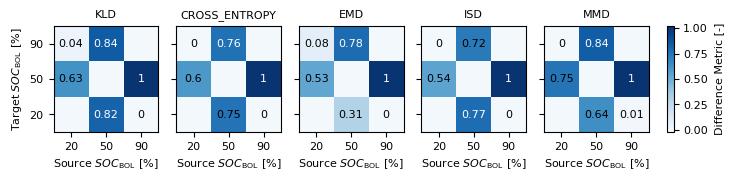

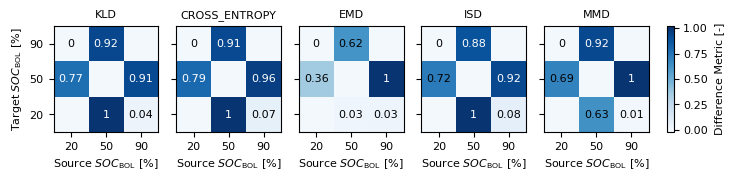

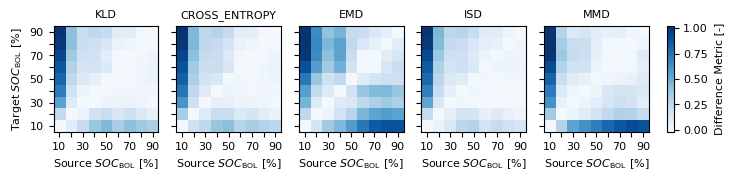

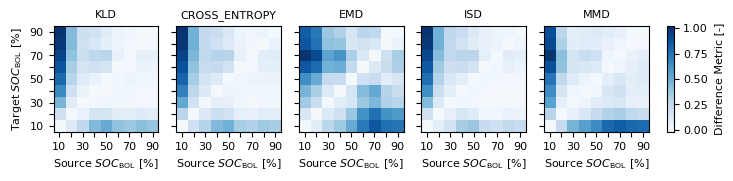

In [15]:
from scripts.modeling.fine_tuning import plot_soc_combination_grid


def plot_distribution_differences(dataset_id:str, pulse_type:str, difference_feature:str='full_voltage', difference_cells:str='source_train_target_train',):
	"""Plots the SOC-combination scores for all DistributionDifference metrics

	Args:
		dataset_id (str): {'UConn-ILCC-LFP', 'UConn-ILCC-NMC'}
		pulse_type (str): {'chg', 'dchg'}
	"""

	assert dataset_id in ['UConn-ILCC-LFP', 'UConn-ILCC-NMC']
	assert pulse_type in ['chg', 'dchg']

	def _get_difference_as_soc_grid(dataset_id:str, pulse_type:str, difference_metric:str, difference_feature:str, difference_cells:str, apply_log:bool=False):
		assert difference_metric in ['kld', 'cross_entropy', 'emd', 'isd', 'mmd']

		# Get processed difference values and finetuning results for specified feature and included cells
		df_diff_res = get_distribution_diffs_all_iterations(feature=difference_feature, cells_included=difference_cells)
		df_filt = df_diff_res.loc[(df_diff_res['dataset_id'] == dataset_id) & (df_diff_res['pulse_type'] == pulse_type)]

		source_socs = np.sort(df_filt['target_soc'].astype(int).unique())
		target_socs = np.sort(df_filt['source_soc'].astype(int).unique())
		res_grid = np.zeros(shape=(len(target_socs), len(source_socs)))
		for i, target_soc in enumerate(target_socs):
			for j, source_soc in enumerate(source_socs):
				if source_soc == target_soc: continue
				df_comb = df_filt.loc[(df_filt['source_soc'].astype(int) == source_soc) & (df_filt['target_soc'].astype(int) == target_soc)]

				if not (difference_metric == 'emd') and apply_log:
					res_grid[i][j] = np.log(df_comb[difference_metric].mean())
				else:
					res_grid[i][j] = df_comb[difference_metric].mean()

		vmin = np.min(res_grid[res_grid!=0])
		vmax = np.max(res_grid[res_grid!=0])
		res_grid = (res_grid - vmin) / (vmax - vmin)
		for i in range(res_grid.shape[0]): res_grid[i][i] = 0
		return res_grid
			
	#region: set up figure
	fig = plt.figure(figsize=(8,1.375))
	gs = GridSpec(figure=fig, nrows=1, ncols=6, width_ratios=[15,15,15,15,15,1])
	axes = [fig.add_subplot(gs[0,0]), fig.add_subplot(gs[0,1]), fig.add_subplot(gs[0,2]), 
			fig.add_subplot(gs[0,3]), fig.add_subplot(gs[0,4]), fig.add_subplot(gs[0,5])]
	for i in range(1,5):
		axes[i].sharex(axes[0])
		plt.setp(axes[i].get_yticklabels(), visible=False)
	#endregion

	soc_bol = r"$SOC_{\mathrm{BOL}}$"
	all_socs = dic_available_dataset_info[dataset_id]['pulse_socs_tested']
	for i, diff_metric in enumerate(['kld', 'cross_entropy', 'emd', 'isd', 'mmd']):
		res_grid = _get_difference_as_soc_grid(
			dataset_id=dataset_id, 
			pulse_type=pulse_type, 
			difference_metric=diff_metric, 
			difference_feature=difference_feature, 
			difference_cells=difference_cells)
		
		#region: plot metric
		soc_labels = all_socs
		if dataset_id == 'UConn-ILCC-NMC':
			soc_labels = [all_socs[i] if i%2==0 else '' for i in range(len(all_socs))]
		fig, _axes, cbar = plot_soc_combination_grid(
			results=res_grid, 
			annotations=res_grid.round(2) if dataset_id == 'UConn-ILCC-LFP' else None,
			fig=fig,
			axes=(axes[i], axes[5]),
			xlabel=f'Source {soc_bol} [%]',
			xticklabels=soc_labels,
			ylabel=f'Target {soc_bol} [%]' if i == 0 else '',
			yticklabels=soc_labels,
			title=diff_metric.upper(),
			cbar_label='Difference Metric [-]',
			annotation_fontsize=5 if dataset_id == 'UConn-ILCC-NMC' else 8)
		_axes[0].title.set_fontsize(8)
		_axes[0].xaxis.label.set_fontsize(8)
		_axes[0].xaxis.set_tick_params(labelsize=8)
		_axes[0].yaxis.label.set_fontsize(8)
		_axes[0].yaxis.set_tick_params(labelsize=8)
		_axes[1].yaxis.label.set_fontsize(8)
		_axes[1].yaxis.set_tick_params(labelsize=8)
		#endregion

	return fig, axes


file_type = 'png'
save = False

for dataset_id in ['UConn-ILCC-LFP', 'UConn-ILCC-NMC']:
	for pulse_type in ['chg', 'dchg']:
		dir_save = dir_figures.joinpath("Information Metrics", "Distribution Difference")
		dir_save.mkdir(exist_ok=True, parents=True)
		filename = f"DistDiff_{dataset_id}_{pulse_type}.{file_type}"

		fig, axes = plot_distribution_differences(
			dataset_id=dataset_id,
			pulse_type=pulse_type,
			difference_feature='full_voltage',
			difference_cells='source_train_target_train')

		if save: fig.savefig(dir_save.joinpath(filename), dpi=300, bbox_inches='tight')
		plt.show()


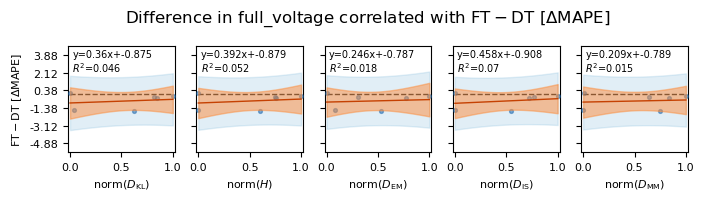

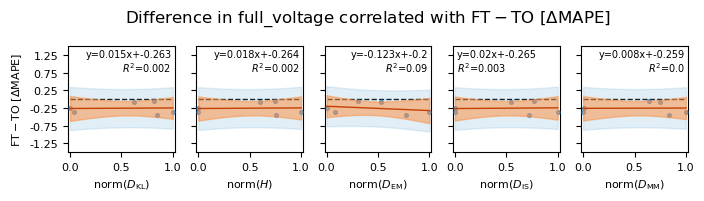

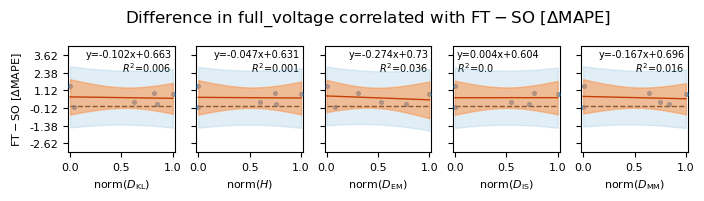

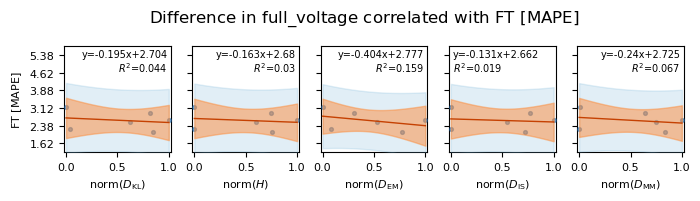

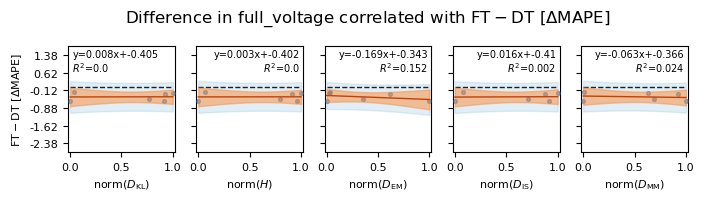

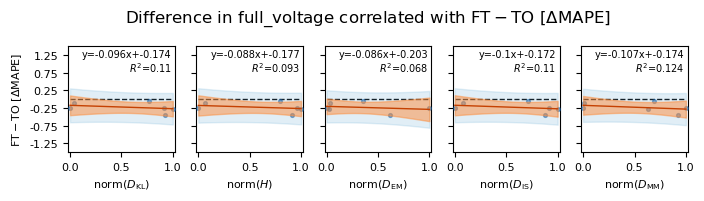

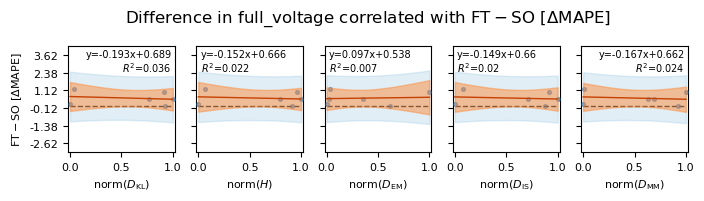

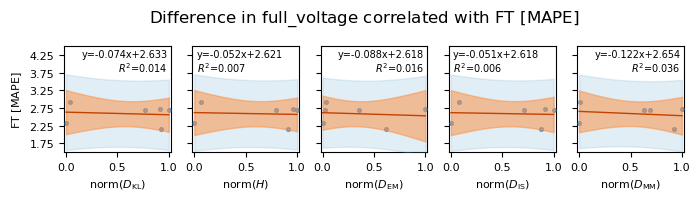

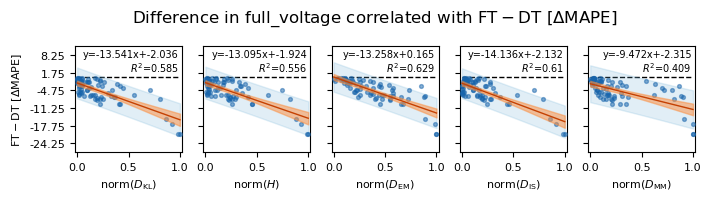

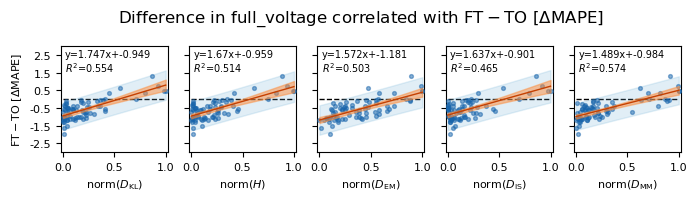

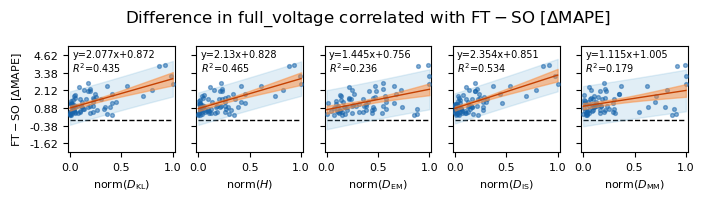

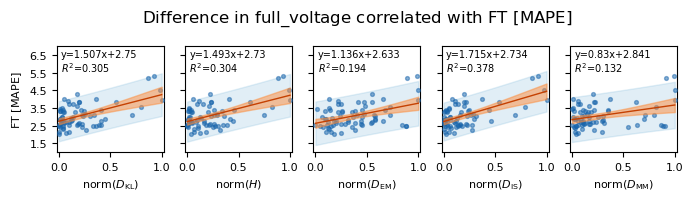

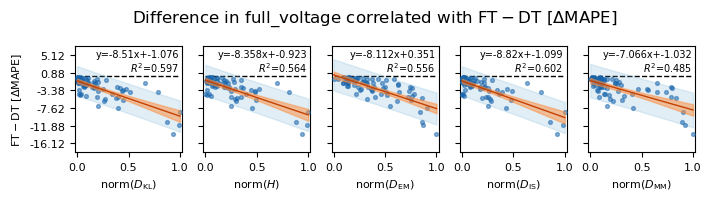

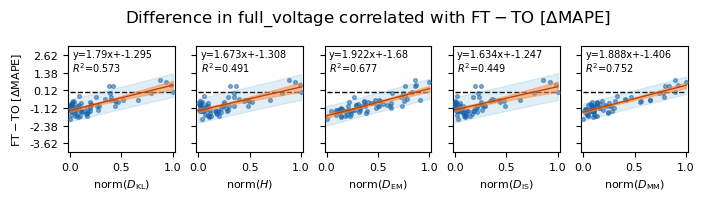

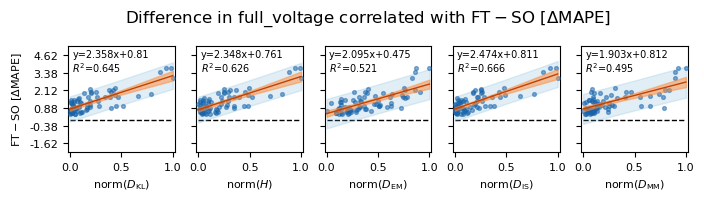

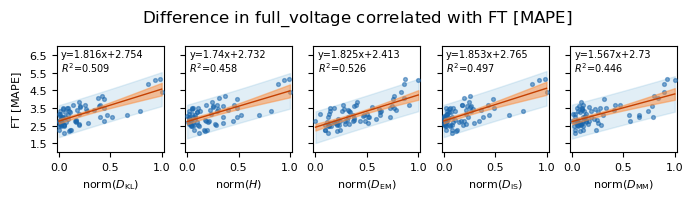

In [16]:
# Correlation scatter plots of FT performance and distribution differences

def calculate_error_distdiff_correlation(
	dataset_id:str, pulse_type:str, results_to_compare=('fine_tuning', 'source_on_target'), result_metric:str='mape', 
	difference_metric:str='kld', difference_feature:str='full_voltage', difference_cells:str='source_train_target_train',
	avg_diff_over_soc:bool=False):
	"""_summary_

	Args:
		dataset_id (str): _description_
		pulse_type (str): _description_
		results_to_compare (tuple, optional): A 1-tuple or 2-tuple of the following {'source_on_source', 'source_on_target', 'fine_tuning', 'target_only'}. Defaults to ('fine_tuning', 'source_on_target').
		result_metric (str, optional): {'mape', 'rmse', 'mae', 'r2'}. Defaults to 'mape'
		difference_metric (str, optional): {'kld', 'cross_entropy', 'emd', 'isd', 'mmd'}. Defaults to 'kullback_leibler'.
		difference_feature (str, optional): {'full_voltage', 'peak', 'endpoints', 'std', 'mean', 'mean_std', 'area', 'pca'}. Defaults to 'full_voltage'.
		difference_cells (str, optional): {'source_train_target_train', 'source_train_target_all', 'source_all_target_all'}. Defaults to 'source_train_target_train'.
		avg_diff_over_soc (bool, optional): Whether to average difference values at each combination of source and target soc. Defaults to False. 
		
	Returns:
		tuple: linear_model, difference_vals, performance_vals
	"""

	# Get processed difference values and finetuning results for specified feature and included cells
	df_diff_res = get_distribution_diffs_all_iterations(feature=difference_feature, cells_included=difference_cells)
	df_filt = df_diff_res.loc[(df_diff_res['dataset_id'] == dataset_id) & (df_diff_res['pulse_type'] == pulse_type)]

	#region: get performance and difference values
	performance_vals = []
	difference_vals = []

	res_keys = np.empty(shape=len(results_to_compare), dtype=object)
	for i in range(len(results_to_compare)):
		if results_to_compare[i] == 'source_on_source': res_keys[i] = f'so_{result_metric}'
		elif results_to_compare[i] == 'source_on_target': res_keys[i] = f'dt_{result_metric}'
		elif results_to_compare[i] == 'fine_tuning': res_keys[i] = f'ft_{result_metric}'
		elif results_to_compare[i] == 'target_only': res_keys[i] = f'to_{result_metric}'
		else: raise ValueError(f"Unknown result: {results_to_compare[i]}")
	for (source_soc, target_soc), df_comb in df_filt.groupby(by=['source_soc', 'target_soc']):
		if avg_diff_over_soc:
			if len(results_to_compare) == 2:
				performance_vals.append(df_comb[res_keys[0]].mean() - df_comb[res_keys[1]].mean())
			elif len(results_to_compare) == 1:
				performance_vals.append(df_comb[res_keys[0]].mean())
			difference_vals.append(df_comb[difference_metric].mean())
		else:
			if len(results_to_compare) == 2:
				performance_vals.append(df_comb[res_keys[0]].values - df_comb[res_keys[1]].values)
			elif len(results_to_compare) == 1:
				performance_vals.append(df_comb[res_keys[0]].values)
			difference_vals.append(df_comb[difference_metric].values)

	performance_vals = np.asarray(performance_vals) * (100 if result_metric == 'mape' else 1)
	difference_vals = np.asarray(difference_vals)
	#endregion

	#region: normalize difference values
	from sklearn.preprocessing import MinMaxScaler
	scaler = MinMaxScaler().fit(difference_vals.reshape(-1,1))
	difference_vals = scaler.transform(difference_vals.reshape(-1,1))
	#endregion

	# fit linear model
	import statsmodels.api as sm
	linear_model = sm.OLS(performance_vals.reshape(-1,1), sm.add_constant(difference_vals.reshape(-1,1))).fit()

	return linear_model, difference_vals, performance_vals

def plot_error_distdiff_correlation(
		dataset_id:str, pulse_type:str, results_to_compare=('fine_tuning', 'source_on_target'), result_metric:str='mape', 
		difference_metric:str='kld', difference_feature:str='full_voltage', difference_cells:str='source_train_target_train',
		avg_diff_over_soc:bool=False, **kwargs):
	"""_summary_

	Args:
		dataset_id (str): _description_
		pulse_type (str): _description_
		results_to_compare (tuple, optional): A 1-tuple or 2-tuple of the following {'source_on_source', 'source_on_target', 'fine_tuning', 'target_only'}. Defaults to ('fine_tuning', 'source_on_target').
		result_metric (str, optional): {'mape', 'rmse', 'mae', 'r2'}. Defaults to 'mape'
		difference_metric (str, optional): {'kld', 'cross_entropy', 'emd', 'isd', 'mmd'}. Defaults to 'kullback_leibler'.
		difference_feature (str, optional): {'full_voltage', 'peak', 'endpoints', 'std', 'mean', 'mean_std', 'area', 'pca'}. Defaults to 'full_voltage'.
		difference_cells (str, optional): {'source_train_target_train', 'source_train_target_all', 'source_all_target_all'}. Defaults to 'source_train_target_train'.
		avg_diff_over_soc (bool, optional): Whether to average difference values at each combination of source and target soc. Defaults to False. 
		**kwargs: {'fig', 'ax', 'title', 'xlabel', 'ylabel', 'alpha', 'show_ci', 'show_pi', 'show_annotations', 'show_zero'}
	"""

	#region: unpack kwargs
	title, xlabel, ylabel = '', '', ''
	if 'title' in kwargs: title = kwargs['title']
	if 'xlabel' in kwargs: xlabel = kwargs['xlabel']
	if 'ylabel' in kwargs: ylabel = kwargs['ylabel']
	alpha = 0.05
	if 'alpha' in kwargs: alpha = kwargs['alpha']
	fig, ax = None, None
	if 'fig' in kwargs and 'ax' in kwargs: 
		fig = kwargs['fig']
		ax = kwargs['ax']
	else:
		fig, ax = plt.subplots(figsize=(4,3))
	show_ci, show_pi = True, True
	if 'show_ci' in kwargs: show_ci = kwargs['show_ci']
	if 'show_pi' in kwargs: show_pi = kwargs['show_pi']
	show_annotations = True
	if 'show_annotations' in kwargs: show_annotations = kwargs['show_annotations']

	show_zero = False
	if 'show_zero' in kwargs: show_zero = True
	#endregion

	#region: calaculate best fit
	import statsmodels.api as sm
	linear_model, difference_vals, performance_vals = calculate_error_distdiff_correlation(
		dataset_id=dataset_id, pulse_type=pulse_type, results_to_compare=results_to_compare,
		result_metric=result_metric, difference_metric=difference_metric, difference_feature=difference_feature,
		difference_cells=difference_cells, avg_diff_over_soc=avg_diff_over_soc)

	# predict best fit line
	x_pred_range = np.linspace(0,1,100).reshape(-1,1)
	y_pred = linear_model.predict(sm.add_constant(x_pred_range))
	
	# get prediction and confidence intervals
	_ = linear_model.conf_int(alpha=alpha, cols=None)
	summary = linear_model.get_prediction(sm.add_constant(x_pred_range)).summary_frame()
	#endregion

	#region: plot
	# plotting layers zorder (back --> front): PI, raw data, CI, best fit
	if show_zero:
		ax.plot([np.min(x_pred_range), np.max(x_pred_range)], [0,0],'k--', linewidth=1.0, zorder=3)

	if show_pi:
		ax.fill_between(
			x_pred_range.flatten(),
			summary['obs_ci_lower'].values,
			summary['obs_ci_upper'].values,
			color=mpl.cm.Blues(0.5), alpha=0.2, 
			label=f'{round((1-alpha)*100)}% PI',
			zorder=5)
	if show_ci:
		ax.fill_between(
			x_pred_range.flatten(),
			summary['mean_ci_lower'].values,
			summary['mean_ci_upper'].values,
			color=mpl.cm.Oranges(0.5), alpha=0.5, 
			label=f'{round((1-alpha)*100)}% CI',
			zorder=9)
	
	ax.scatter(
		difference_vals,
		performance_vals, 
		color=mpl.cm.Blues(0.8), alpha=(0.5 if len(difference_vals) < 100 else 0.2), 
		marker='.', s=2 if len(difference_vals) > 100 else 30, 
		label='Data',
		zorder=7)
	ax.plot(
		x_pred_range, y_pred, '-', linewidth=1,
		color=mpl.cm.Oranges(0.8), alpha=1.0, 
		label='Fit',
		zorder=11)
	
	if not title == '': ax.set_title(title)
	if not xlabel == '': ax.set_xlabel(xlabel, fontsize=8)
	if not ylabel == '': ax.set_ylabel(ylabel, fontsize=8)
	ax.set_xlim(-0.02,1.02)
	ax.set_xticks(np.arange(0,1.001,0.25))
	#endregion

	params_dict = {
		'y_true': performance_vals, 
		'y_pred': linear_model.predict(sm.add_constant(difference_vals)),
		'x_true': difference_vals,
		'ci_x': x_pred_range,
		'ci_lower': summary['mean_ci_lower'].values,
		'ci_upper': summary['mean_ci_upper'].values,
		'pi_x': x_pred_range,
		'pi_lower': summary['obs_ci_lower'].values,
		'pi_upper': summary['obs_ci_upper'].values,
		'coefficients':linear_model.params
	}
	
	r2 = r2_score(params_dict['y_true'], params_dict['y_pred'])
	intercept, slope = params_dict['coefficients']
	
	#region: set ft performance tick labels
	n_ticks = 6
	ymax = np.max(np.hstack([params_dict['y_true'], params_dict['pi_upper']]))
	ymax = np.sign(ymax) * np.ceil(abs(ymax))
	ymin = np.min(np.hstack([params_dict['y_true'], params_dict['pi_lower']]))
	ymin = np.sign(ymin) * np.ceil(abs(ymin))
	
	ydelta = round((ymax-ymin)/(n_ticks-2), 2)
	perf_ticks = np.arange(ymin-ydelta/2, ymax+ydelta/2+1e-6, ydelta)
	ax.set_yticks(perf_ticks, np.round(perf_ticks, 2), fontsize=8)
	ax.set_ylim(ymin-(ydelta), ymax+(ydelta))
	#endregion

	#region: add annotations
	if show_annotations:
		increasing = True
		sort_idxs = np.argsort(params_dict['x_true'].flatten())
		if np.mean(params_dict['y_true'].flatten()[sort_idxs][0:2]) > np.mean(params_dict['y_true'].flatten()[sort_idxs][-2:]): increasing = False
		if increasing:
			ax.annotate(f"y={round(slope,3)}x+{round(intercept,3)}", xy=(0.04,0.90), xycoords='axes fraction', ha='left', fontsize=7)
			ax.annotate(f"$R^2$={round(r2, 3)}", xy=(0.04,0.76), xycoords='axes fraction', ha='left', fontsize=7)
		else:
			ax.annotate(f"y={round(slope,3)}x+{round(intercept,3)}", xy=(0.97,0.90), xycoords='axes fraction', ha='right', fontsize=7)
			ax.annotate(f"$R^2$={round(r2, 3)}", xy=(0.97,0.76), xycoords='axes fraction', ha='right', fontsize=7)
	#endregion

	return fig, ax, params_dict


feature = 'full_voltage' 							# 'full_voltage', 'peak', 'endpoints', 'std', 'mean', 'mean_std', 'area', 'pca'
groups_to_compare = 'source_train_target_train'		# 'source_train_target_train', 'source_train_target_all', 'source_all_target_all'
file_type = 'png'
avg_socs = True
save = False

for dataset_id in ['UConn-ILCC-LFP', 'UConn-ILCC-NMC']:
	for pulse_type in ['chg', 'dchg']:
		dir_save = dir_figures.joinpath("Information Metrics", "Correlation with Error", "Linear Regression", "Scatter Plots", f"{dataset_id} {pulse_type.upper()}")
		dir_save.mkdir(exist_ok=True, parents=True)

		comparison_map = {
			0:{'results_to_compare':('fine_tuning', 'source_on_target'), 
	  		   'label':r"$\mathrm{FT}-\mathrm{DT}\ [\Delta \mathrm{MAPE}]$",
			   'filename':'(FT-DT)'},
			1:{'results_to_compare':('fine_tuning', 'target_only'), 
	  		   'label':r"$\mathrm{FT}-\mathrm{TO}\ [\Delta \mathrm{MAPE}]$",
			   'filename':'(FT-TO)'},
			2:{'results_to_compare':('fine_tuning', 'source_on_source'), 
	  		   'label':r"$\mathrm{FT}-\mathrm{SO}\ [\Delta \mathrm{MAPE}]$",
			   'filename':'(FT-SO)'},
			3:{'results_to_compare':('fine_tuning',), 
	  		   'label':r"$\mathrm{FT}\ [\mathrm{MAPE}]$",
			   'filename':'(FT)'},
		}
		for k,vals in comparison_map.items():
			comparison = vals['results_to_compare']
			comparison_label = vals['label']
		
			fig, axes = plt.subplots(figsize=(8,1.375), ncols=5, sharey=True)
			for i in range(1,5):
				plt.setp(axes[i].get_yticklabels(), visible=False)
				xlabel_map = {
					'kld':r"$\mathrm{norm}(D_{\mathrm{KL}})$",
					'cross_entropy':r"$\mathrm{norm}(H)$",
					'emd':r"$\mathrm{norm}(D_{\mathrm{EM}})$",
					'isd':r"$\mathrm{norm}(D_{\mathrm{IS}})$",
					'mmd':r"$\mathrm{norm}(D_{\mathrm{MM}})$",
				}
			for i, diff_metric in enumerate(['kld', 'cross_entropy', 'emd', 'isd', 'mmd']):
				fig, axes[i], data = plot_error_distdiff_correlation(
					dataset_id=dataset_id, 
					pulse_type=pulse_type, 
					results_to_compare=comparison,
					result_metric='mape', 
					difference_metric=diff_metric, 
					difference_feature=feature, 
					difference_cells=groups_to_compare,
					avg_diff_over_soc=avg_socs,
					fig=fig,
					ax=axes[i],
					xlabel=xlabel_map[diff_metric],
					show_zero=True
				)
				axes[i].set_xticks(np.arange(0,1.001,0.5), np.arange(0,1.001,0.5), fontsize=8)
				if i == 0:
					axes[i].set_ylabel(comparison_label, fontsize=8)

			fig.suptitle(f"Difference in {feature} correlated with {comparison_label}", y=1.15)
			
			filename = f"{vals['filename']} {feature} {groups_to_compare} {'Avg' if avg_socs else 'AllTrials'}.{file_type}"
			if save: fig.savefig(dir_save.joinpath(filename), dpi=300, bbox_inches='tight')
			plt.show()



In [18]:
# Bar charts
def plot_error_distdiff_correlation_bar(
	dataset_id:str, pulse_type:str, results_to_compare:tuple=('fine_tuning', 'source_on_target'),
	result_metric:str='mape', difference_cells:str='source_train_target_train', avg_diff_over_soc:bool=True,
	**kwargs):
		
	bar_width = 0.16
	figsize=(6,1.5)

	feature_map = {
		0:{'feature':'full_voltage', 
			'label':r"$\mathbf{x}$"   },
		1:{'feature':'endpoints', 
			'label':r"$\mathbf{x}_{\mathrm{endpoints}}$"   },
		2:{'feature':'peak', 
			'label':r"$x_{\mathrm{peak}}$"   },
		3:{'feature':'mean', 
			'label':r"$\mathrm{mean}(\mathbf{x})$"   },
		4:{'feature':'std', 
			'label':r"$\mathrm{std}(\mathbf{x})$"   },
		5:{'feature':'area', 
			'label':r"$\int x dt$"   },
		# 6:{'feature':'pca', 
		# 	'label':r"$\mathrm{PCA-2}$"   },
		# 7:{'feature':'pca_v2', 
		# 	'label':r"$\mathrm{PCA-2}$"   },
		6:{'feature':'pca5', 
			'label':r"$\mathrm{PCA}$"   },
		# 9:{'feature':'pca5_v2', 
		# 	'label':r"$\mathrm{PCA-5}$"   },
	}
	difference_metric_map = {
		0:{'metric':'kld', 
			'label':r"$\mathrm{norm}(D_{\mathrm{KL}})$", 
			'hatch':"///", 	},
		1:{'metric':'cross_entropy', 
			'label':r"$\mathrm{norm}(H)$", 
			'hatch':"\\\\\\", 	},
		2:{'metric':'emd', 
			'label':r"$\mathrm{norm}(D_{\mathrm{EM}})$", 
			'hatch':"OO", 	},
		3:{'metric':'isd', 
			'label':r"$\mathrm{norm}(D_{\mathrm{IS}})$", 
			'hatch':"...", 	},
		4:{'metric':'mmd', 
			'label':r"$\mathrm{norm}(D_{\mathrm{MM}})$", 
			'hatch':"xxx", 	},
	}

	#region: unpack kwargs
	fig, ax = None, None
	if 'fig' in kwargs and 'ax' in kwargs: 
		fig = kwargs['fig']
		ax = kwargs['ax']
	else:
		fig, ax = plt.subplots(figsize=figsize)
		
	xlabel_fontsize = 8
	if 'xlabel_fontsize' in kwargs: xlabel_fontsize = kwargs['xlabel_fontsize']
	xticklabel_fontsize = 9
	if 'xticklabel_fontsize' in kwargs: xticklabel_fontsize = kwargs['xticklabel_fontsize']
	ylabel_fontsize = 9
	if 'ylabel_fontsize' in kwargs: ylabel_fontsize = kwargs['ylabel_fontsize']
	yticklabel_fontsize = 8
	if 'yticklabel_fontsize' in kwargs: yticklabel_fontsize = kwargs['yticklabel_fontsize']
	legend_fontsize = 7
	if 'legend_fontsize' in kwargs: legend_fontsize = kwargs['legend_fontsize']
	legend_ncols = 5
	if 'legend_ncols' in kwargs: legend_ncols = kwargs['legend_ncols']
	#endregion

	best_r2 = 0
	best_feature = None
	best_difference_metric = None
	best_bar = {
		'x':None, 'height':None, 'hatch':None, 
		'width':bar_width, 'align':'edge', 'edgecolor':'k', 'linewidth':1, 'color':mpl.cm.Blues(0.5)
	}
	for i, f_dict in feature_map.items():
		difference_feature = f_dict['feature']
		for j, d_dict in difference_metric_map.items():
			difference_metric = d_dict['metric']
			x_loc = (i-(bar_width*2.5)) + (j*bar_width)

			#region: get the R2 score for this comparison & feature
			import statsmodels.api as sm
			linear_model, difference_vals, performance_vals = calculate_error_distdiff_correlation(
				dataset_id=dataset_id, pulse_type=pulse_type, results_to_compare=results_to_compare,
				result_metric=result_metric, difference_metric=difference_metric, difference_feature=difference_feature,
				difference_cells=difference_cells, avg_diff_over_soc=avg_diff_over_soc)
			r2 = r2_score(performance_vals, linear_model.predict(sm.add_constant(difference_vals)))
			if r2 > best_r2: 
				best_r2 = r2
				best_feature = difference_feature
				best_difference_metric = difference_metric
				best_bar['x'] = x_loc
				best_bar['height'] = r2
				best_bar['hatch'] = d_dict['hatch']
			#endregion

			ax.bar(
				x_loc, r2, width=bar_width, align='edge',
				hatch=d_dict['hatch'], edgecolor='k', linewidth=1,
				color='#999999')
	
	#region: highlight best bar
	ax.bar(**best_bar)
	#endregion

	handles = [
		mpl.patches.Rectangle(
			xy=(0,0), width=0.5, height=0.5, 
			facecolor='#999999', hatch=d_dict['hatch'], edgecolor='k', linestyle='-',
			label=d_dict['label']
		)
		for d_dict in difference_metric_map.values()]
	ax.legend(
		handles=handles, handlelength=1.25, handleheight=1.25,
		loc='upper center', ncols=legend_ncols, fontsize=legend_fontsize)

	ax.set_ylabel(r"$R^2$ [-]", fontsize=ylabel_fontsize)
	ax.set_yticks(np.arange(0,1.0001, 0.25), [f"{x:.02f}" for x in np.arange(0,1.0001, 0.25)], fontsize=yticklabel_fontsize)
	ax.set_ylim([0.0,1.08])
	# ax.set_xlabel("Feature", fontsize=xlabel_fontsize)
	ax.set_xticks(list(feature_map.keys()), [feature_map[k]['label'] for k in feature_map.keys()], fontsize=xticklabel_fontsize)
	fig.align_labels()
	
	params = {
		'feature_map':feature_map, 'difference_metric_map':difference_metric_map,
		'best_feature':best_feature, 'best_difference_metric':best_difference_metric,
	}
	return fig, ax, params


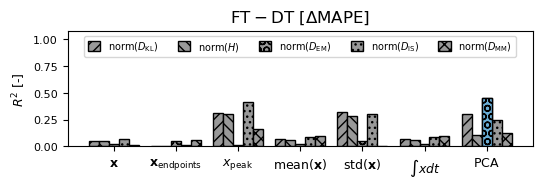

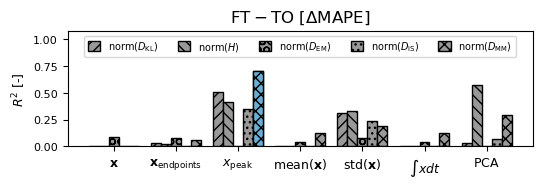

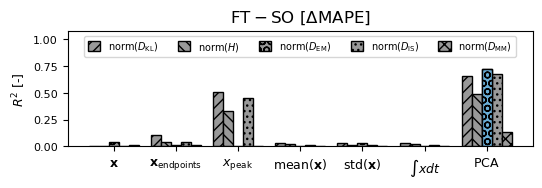

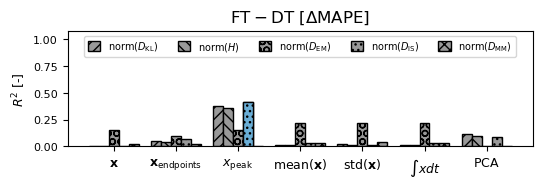

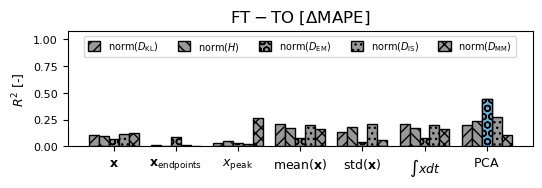

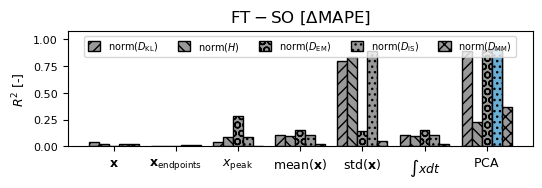

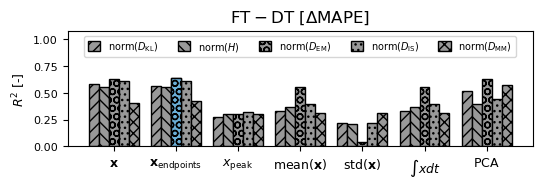

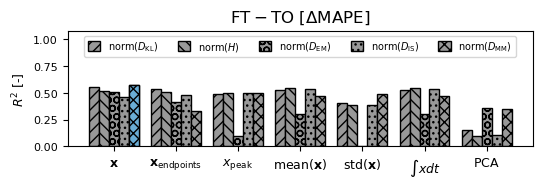

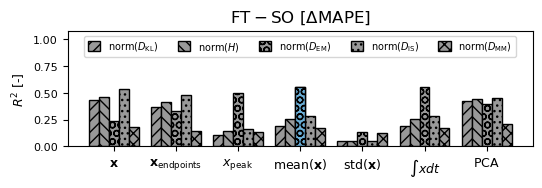

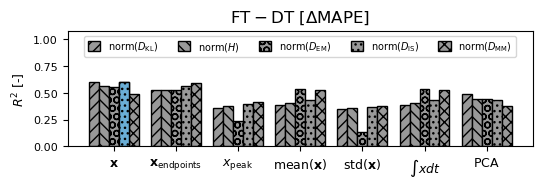

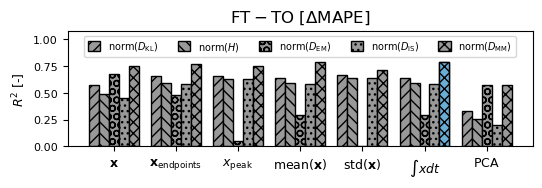

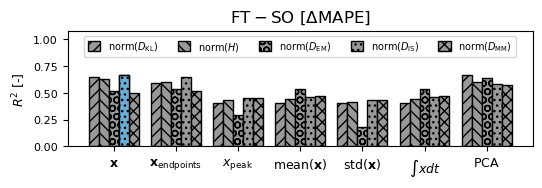

In [19]:
groups_to_compare = 'source_train_target_train'
avg_socs = True
file_type = 'png'
save = False

for dataset_id in ['UConn-ILCC-LFP', 'UConn-ILCC-NMC']:
	for pulse_type in ['chg', 'dchg']:
		dir_save = dir_figures.joinpath(
			"Information Metrics", "Correlation with Error", \
			"Linear Regression", "Bar Charts", f"{dataset_id} {pulse_type.upper()}")
		dir_save.mkdir(exist_ok=True, parents=True)

		comparison_map = {
			0:{'results_to_compare':('fine_tuning', 'source_on_target'), 
	  		   'label':r"$\mathrm{FT}-\mathrm{DT}\ [\Delta \mathrm{MAPE}]$",
			   'filename':'(FT-DT)'},
			1:{'results_to_compare':('fine_tuning', 'target_only'), 
	  		   'label':r"$\mathrm{FT}-\mathrm{TO}\ [\Delta \mathrm{MAPE}]$",
			   'filename':'(FT-TO)'},
			2:{'results_to_compare':('fine_tuning', 'source_on_source'), 
	  		   'label':r"$\mathrm{FT}-\mathrm{SO}\ [\Delta \mathrm{MAPE}]$",
			   'filename':'(FT-SO)'},
		}
		for k,vals in comparison_map.items():
			comparison = vals['results_to_compare']

			fig, ax, params = plot_error_distdiff_correlation_bar(
				dataset_id=dataset_id, pulse_type=pulse_type, results_to_compare=comparison,
				result_metric='mape', difference_cells=groups_to_compare, avg_diff_over_soc=avg_socs)
			ax.set_title(vals['label'])
			filename = f"BarChart {vals['filename']} {groups_to_compare} {'Avg' if avg_socs else 'AllTrials'}.{file_type}"
			if save: fig.savefig(dir_save.joinpath(filename), dpi=300, bbox_inches='tight')
			plt.show()

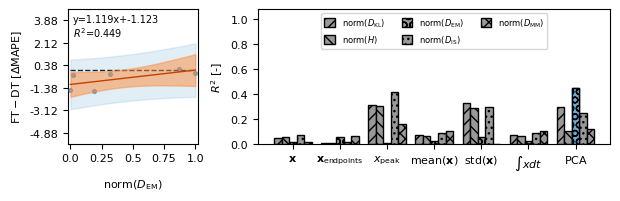

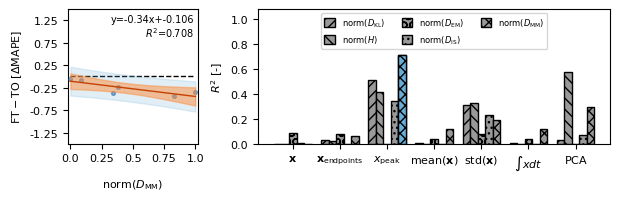

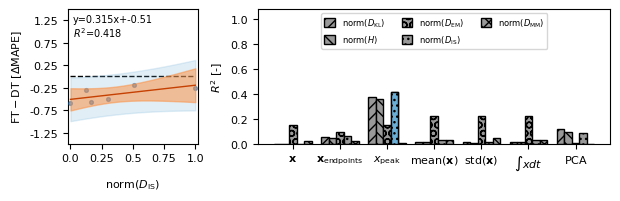

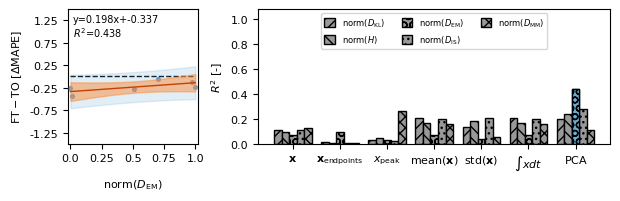

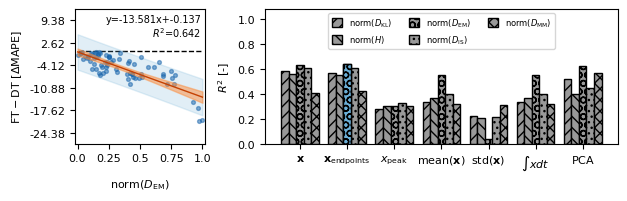

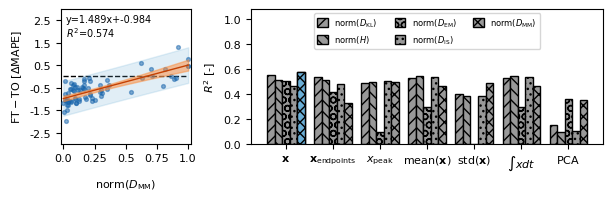

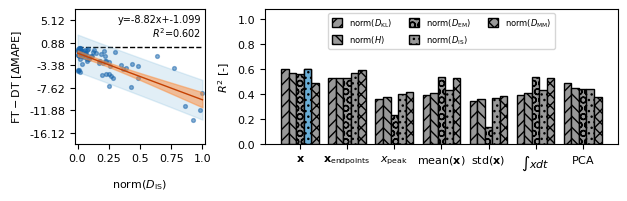

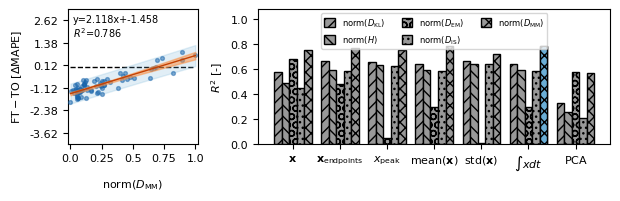

In [20]:

def plot_error_distdiff_correlation_best_bar(dataset_id:str, pulse_type:str, comparison:str=('fine_tuning', 'source_on_target')):
	"""
	Args:
		dataset_id (str): {'UConn-ILCC-LFP', 'UConn-ILCC-NMC'}
		pulse_type (str): {'chg', 'dchg'}
		comparison (str, optional): A 2-tuple of the following {'source_on_source', 'source_on_target', 'fine_tuning', 'target_only'}. Defaults to ('fine_tuning', 'source_on_target').
	"""

	comparison_keys = [None, None]
	for i in range(2):
		if comparison[i] == 'fine_tuning': comparison_keys[i] = 'FT'
		elif comparison[i] == 'source_on_source': comparison_keys[i] = 'SO'
		elif comparison[i] == 'source_on_target': comparison_keys[i] = 'DT'
		elif comparison[i] == 'target_only': comparison_keys[i] = 'TO'
	comparison_label = fr"$\mathrm{{{comparison_keys[0]}}}-\mathrm{{{comparison_keys[1]}}}\ [\Delta \mathrm{{MAPE}}]$"

	fig = plt.figure(figsize=(7,1.75))
	gs = GridSpec(figure=fig, nrows=1, ncols=2, width_ratios=[1.75,4.75], wspace=0.25)
	axes = [fig.add_subplot(gs[0]), fig.add_subplot(gs[1])]

	fig, axes[1], params = plot_error_distdiff_correlation_bar(
		dataset_id=dataset_id,
		pulse_type=pulse_type,
		results_to_compare=comparison,
		result_metric='mape',
		difference_cells='source_train_target_train',
		avg_diff_over_soc=True,
		fig=fig,
		ax=axes[1],
		xlabel_fontsize=8,
		xticklabel_fontsize=8,
		ylabel_fontsize=8,
		yticklabel_fontsize=8,
		legend_fontsize=6,
		legend_ncols=3,
	)
	diff_metric_map = {
		'kld':r"$\mathrm{norm}(D_{\mathrm{KL}})$",
		'cross_entropy':r"$\mathrm{norm}(H)$",
		'emd':r"$\mathrm{norm}(D_{\mathrm{EM}})$",
		'isd':r"$\mathrm{norm}(D_{\mathrm{IS}})$",
		'mmd':r"$\mathrm{norm}(D_{\mathrm{MM}})$",
	}
	fig, axes[0], data = plot_error_distdiff_correlation(
		dataset_id=dataset_id, pulse_type=pulse_type, results_to_compare=comparison,
		result_metric='mape', difference_metric=params['best_difference_metric'], difference_feature=params['best_feature'],
		difference_cells='source_train_target_train', avg_diff_over_soc=True, 
		
		fig=fig,
		ax=axes[0],
		show_annotations=False,
		show_zero=True,
	)

	axes[1].set_yticks(np.arange(0,1.001,0.2), [f"{x:.01f}" for x in np.arange(0,1.001,0.2)], fontsize=8)
	axes[0].set_xticks(np.arange(0,1.001,0.25), np.arange(0,1.001,0.25), fontsize=8)
	axes[0].set_xlabel(diff_metric_map[params['best_difference_metric']], fontsize=8)
	axes[0].set_ylabel(comparison_label, fontsize=8)
	r2 = r2_score(data['y_true'], data['y_pred'])
	intercept, slope = data['coefficients']

	#region: set ft performance tick labels
	n_ticks = 6
	ymax = np.max(np.hstack([data['y_true'], data['pi_upper']]))
	ymax = np.sign(ymax) * np.ceil(abs(ymax))
	ymin = np.min(np.hstack([data['y_true'], data['pi_lower']]))
	ymin = np.sign(ymin) * np.ceil(abs(ymin))
	
	ydelta = round((ymax-ymin)/(n_ticks-2), 2)
	perf_ticks = np.arange(ymin-ydelta/2, ymax+ydelta/2+1e-6, ydelta)
	ax.set_yticks(perf_ticks, np.round(perf_ticks, 2), fontsize=8)
	# ax.set_ylim(ymin-(ydelta), ymax+(ydelta))
	#endregion

	#region: add annotations
	increasing = True
	sort_idxs = np.argsort(data['x_true'].flatten())
	if np.mean(data['y_true'].flatten()[sort_idxs][0:2]) > np.mean(data['y_true'].flatten()[sort_idxs][-2:]): increasing = False
	if increasing:
		axes[0].annotate(f"y={round(slope,3)}x+{round(intercept,3)}", xy=(0.04,0.90), xycoords='axes fraction', ha='left', fontsize=7)
		axes[0].annotate(f"$R^2$={round(r2, 3)}", xy=(0.04,0.79), xycoords='axes fraction', ha='left', fontsize=7)
	else:
		axes[0].annotate(f"y={round(slope,3)}x+{round(intercept,3)}", xy=(0.97,0.90), xycoords='axes fraction', ha='right', fontsize=7)
		axes[0].annotate(f"$R^2$={round(r2, 3)}", xy=(0.97,0.79), xycoords='axes fraction', ha='right', fontsize=7)
	#endregion

	return fig, axes, {'comparison_keys':comparison_keys}



file_type = 'png'
save = False

for dataset_id in ['UConn-ILCC-LFP', 'UConn-ILCC-NMC']:
	for pulse_type in ['chg', 'dchg']:
		for comparison in [('fine_tuning', 'source_on_target'), ('fine_tuning', 'target_only')]:
				
			fig, axes, misc = plot_error_distdiff_correlation_best_bar(
				dataset_id=dataset_id, 
				pulse_type=pulse_type, 
				comparison=comparison
			)
			dir_save = dir_figures.joinpath("Information Metrics", "Correlation with Error", "Linear Regression", "Bar and Scatter", f"{dataset_id} {pulse_type.upper()}")
			dir_save.mkdir(exist_ok=True, parents=True)
			filename = f"BarScatter ({misc['comparison_keys'][0]}-{misc['comparison_keys'][1]}).{file_type}"
			if save: fig.savefig(dir_save.joinpath(filename), dpi=600, bbox_inches='tight')
			plt.show()